In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ---------------------- DESCARGA DE DATOS ----------------------
tickers = ['AAPL', 'MSFT', 'IBM', 'GE', 'XOM', 'JNJ', 'WMT']
commodities = ['GLD', 'USO']
all_tickers = tickers + commodities

data = yf.download(all_tickers, start="2007-01-01", end="2024-12-31")['Close']
data = data.dropna(how='all')

# ---------------------- IMPUTACIÓN DE DATOS ----------------------
imputer = SimpleImputer(strategy='mean')
imputed_values = imputer.fit_transform(data)
imputed_data = pd.DataFrame(imputed_values, columns=data.columns, index=data.index)

# ---------------------- NORMALIZACIÓN POR ACTIVO ----------------------
scaler = StandardScaler()
scaled_values = scaler.fit_transform(imputed_data)
scaled_data = pd.DataFrame(scaled_values, columns=data.columns, index=data.index)


[*********************100%***********************]  9 of 9 completed


Se hace tomando las mismas consideraciones de la tartea pasada, es decir
desde el 2007 para evitar NaN lo mas posible

In [ ]:
# ---------------------- CONSTRUCCIÓN DE SERIES ----------------------
N = 3000
T = 101
M = len(scaled_data.columns)

series_list = []
for _ in range(N):
    start_idx = np.random.randint(0, len(scaled_data) - T)
    window = scaled_data.iloc[start_idx:start_idx + T].values.T  # (M, T)
    series_list.append(window)

series_array = np.stack(series_list)  # (N, M, T)
X = series_array[:, :, :-1]  # (N, M, 100)
Y = series_array[:, :, 1:]   # (N, M, 100)

X_tf = np.transpose(X, (0, 2, 1))  # (N, 100, M)
Y_tf = np.transpose(Y, (0, 2, 1))  # (N, 100, M)


In [ ]:

# ---------------------- POSICIONAL ENCODING ----------------------
def positional_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    angle_rads = pos * angle_rates
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.cast(angle_rads, dtype=tf.float32)

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, seq_len, d_model):
        super().__init__()
        self.pos_encoding = positional_encoding(seq_len, d_model)[tf.newaxis, ...]

    def call(self, x):
        return x + self.pos_encoding

In [ ]:
# ---------------------- MODELO TRANSFORMER ----------------------
def build_transformer_model(seq_len=100, num_features=M, num_heads=3, num_layers=3, d_model=64, ff_dim=128):
  #usamos un modelo simple con tres cabezas de atenttion
    inputs = tf.keras.Input(shape=(seq_len, num_features))
    x = tf.keras.layers.Dense(d_model)(inputs)
    x = PositionalEncoding(seq_len, d_model)(x)

    for _ in range(num_layers):
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        attn_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x1, x1)
        x2 = tf.keras.layers.Add()([x, attn_output])
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        ffn_output = tf.keras.layers.Dense(ff_dim, activation='relu')(x3)
        ffn_output = tf.keras.layers.Dense(d_model)(ffn_output)
        x = tf.keras.layers.Add()([x2, ffn_output])

    outputs = tf.keras.layers.Dense(num_features)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

model = build_transformer_model()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 100, 64)   │        640 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 100, 64)   │          0 │ dense_8[0][0]     │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 64)   │        128 │ positional_encod… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 64)   │     49,792 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 100, 64)   │          0 │ positional_encod… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 64)   │        128 │ add_6[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 100, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 100, 64)   │      8,256 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 100, 64)   │          0 │ add_6[0][0],      │
│                     │                   │            │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 64)   │        128 │ add_7[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 64)   │     49,792 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 100, 64)   │          0 │ add_7[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 64)   │        128 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 100, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 100, 64)   │      8,256 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 100, 64)   │          0 │ add_8[0][0],      │
│                     │                   │            │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 64)   │        128 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 201,097 (785.54 KB)

 Trainable params: 201,097 (785.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ---------------------- ENTRENAMIENTO ----------------------
history = model.fit(
    X_tf, Y_tf,
    epochs=50, #con 50 épocas se tuvo mejor resultado que con 20 y 30 y no tardaba tanto el entrenamiento
    batch_size=32,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - loss: 0.9519 - val_loss: 0.0353
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0284 - val_loss: 0.0166
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0150 - val_loss: 0.0109
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0100 - val_loss: 0.0078
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0078 - val_loss: 0.0085
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0065 - val_loss: 0.0071
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0069 - val_loss: 0.0047
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0054 - val_loss: 0.0107
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0060 - val_loss: 0.0040
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0033 - v

In [ ]:
# ---------------------- PREDICCIÓN PARA ÚLTIMA FECHA ----------------------
last_series = scaled_data.iloc[-101:].values.T  # (M, T)
X_last = last_series[:, :-1]  # (M, 100)
Y_real = last_series[:, 1:]   # (M, 100)

X_last_tf = np.expand_dims(X_last.T, axis=0)  # (1, 100, M)
Y_pred_last = model.predict(X_last_tf)  # (1, 100, M)
Y_pred_last = Y_pred_last[0].T  # (M, 100)

# ---------------------- DESNORMALIZACIÓN ----------------------
# Tomamos la última ventana para Y real para comparar en escala original
#para recueracion de los datos en su escala real
real_window_scaled = Y_real.T  # (100, M)
pred_window_scaled = Y_pred_last.T  # (100, M)

real_window_original = scaler.inverse_transform(real_window_scaled)
pred_window_original = scaler.inverse_transform(pred_window_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step


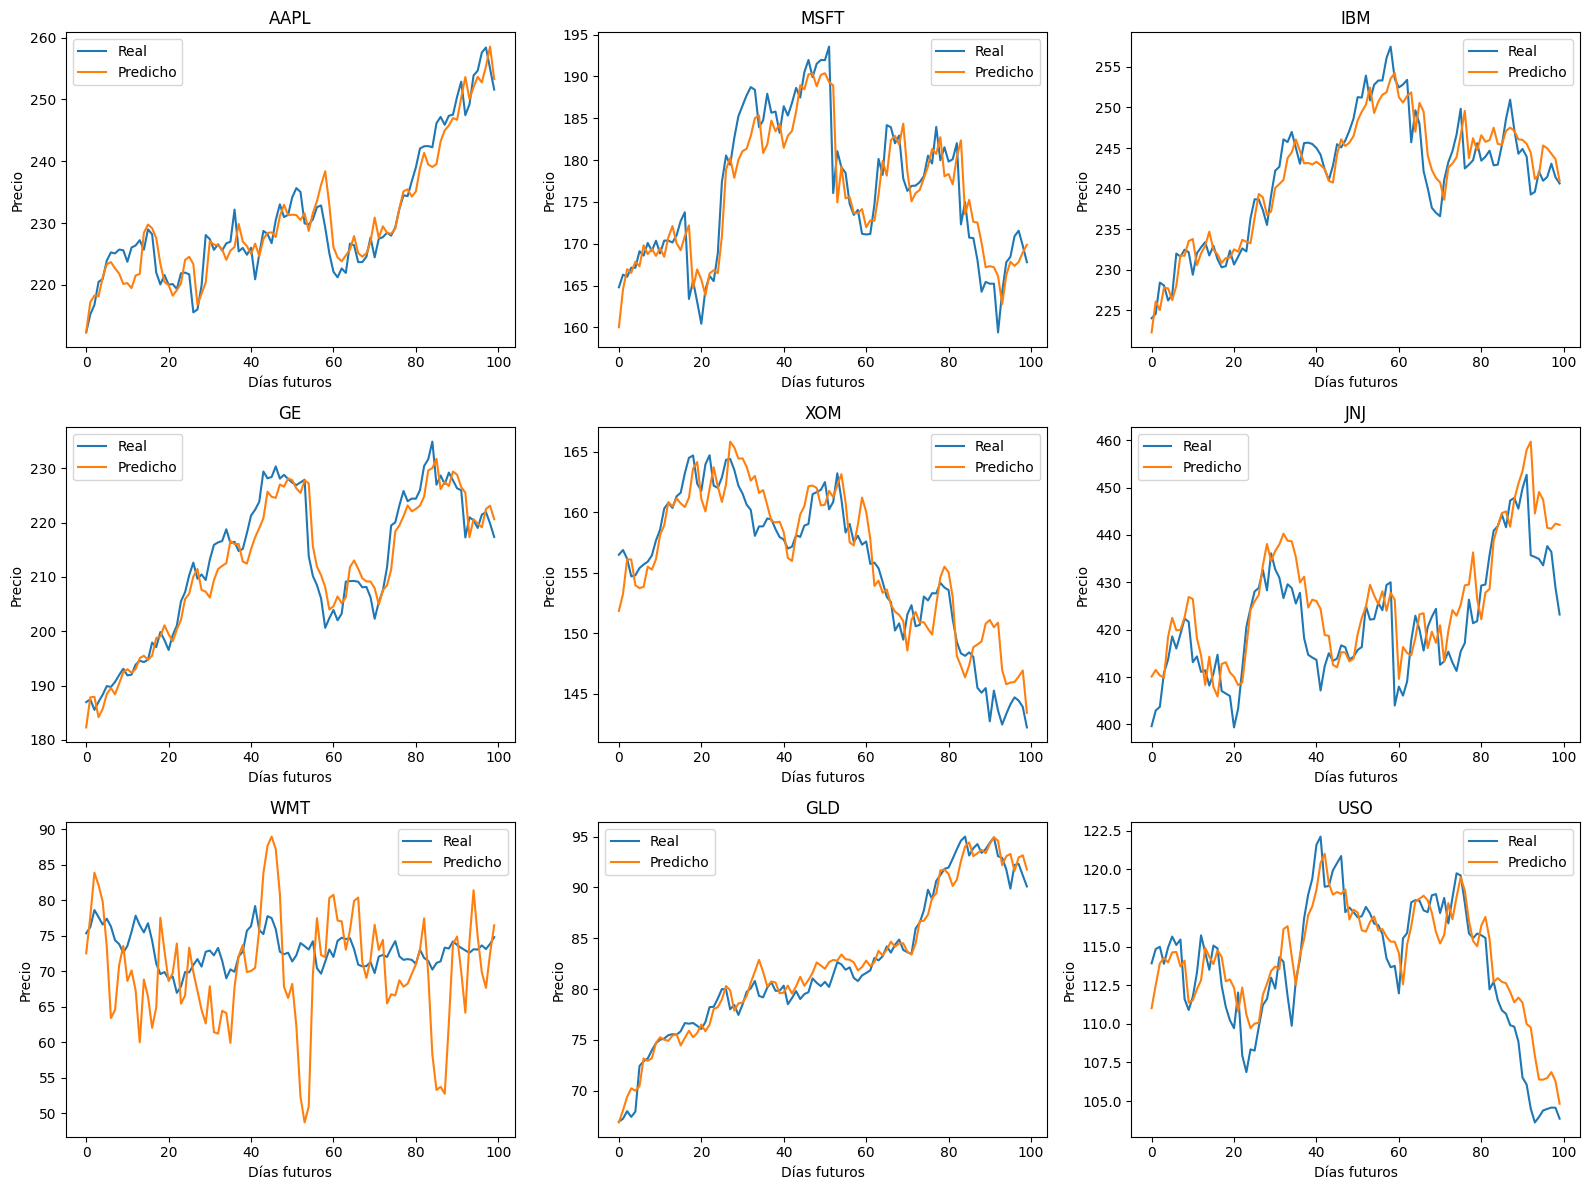

In [ ]:

# ---------------- VISUALIZACIÓN -------
tickers_full = tickers + commodities

plt.figure(figsize=(16, 12))
for i, name in enumerate(tickers_full):
    plt.subplot(3, 3, i + 1)
    plt.plot(real_window_original[:, i], label='Real')
    plt.plot(pred_window_original[:, i], label='Predicho')
    plt.title(name)
    plt.xlabel("Días futuros")
    plt.ylabel("Precio")
    plt.legend()
plt.tight_layout()
plt.show()

Podemos observar que las gráficas de la predicción se asemejan muchoa a la de los datos reales en la mayoría de las acciones

Para comparar el modelo con la estrategia de no hacer nada:
La estrategia de redecir quee el ultimo valor al anterior es una estrategia que se llama estrategia de naive y es el equivalente a no hacer nada(como se pide la comparación en la tarea)

Entonces si mse_transformer < mse_naive, entonces el transformer supera la estrategia trivial, que en la práctica es dificil ganarle.


In [ ]:
# 1. Predicción naive: repite el último valor de cada serie como predicción
naive_pred = np.repeat(X[:, :, -1][:, :, np.newaxis], 100, axis=2)  # (N, M, 100)

# 2. Cálculo de error (MSE) para el modelo y el naive
mse_model = np.mean((Y - np.transpose(model.predict(X_tf), (0, 2, 1)))**2)
mse_naive = np.mean((Y - naive_pred)**2)

print(f"MSE del modelo Transformer: {mse_model:.6f}")
print(f"MSE del modelo naive: {mse_naive:.6f}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
MSE del modelo Transformer: 0.001329
MSE del modelo naive: 0.059308


Como observamos el error cuadrático medio del modelo del transformer es menor al naive, por lo tanto podemos decir que con este modelo le ganamos a la solución trivial